### Lihu Gelem, 300005030
### Jonathan Benhamou, 206822991

### Notebook is running on EMR

In [1]:
# Finding pyspark path
import findspark
findspark.init()

In [2]:
# Imports
import pandas as pd
import matplotlib
import time
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.ml.feature import Imputer
from sklearn import preprocessing
from pyspark.ml.feature import StandardScaler
from datetime import date, timedelta, datetime
from pyspark.sql.functions import lag
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics


### 1-3) Building a classification machine learning model that tries to predict if the fare is lower or higher then $10

## Initialization of a Spark Session and getting the data

In [3]:
sc = SparkSession.builder.appName("FinalProjectBigDataPlatform")\
    .config ("spark.sql.shuffle.partitions", "50") \
    .config("spark.driver.maxResultSize","5g") \
    .config ("spark.sql.execution.arrow.pyspark.enabled", "false")\
    .getOrCreate()

In [4]:
%%time
# Getting the training and test data
!kaggle competitions download -f idc_train.csv idc-big-data-ml-competition
!kaggle competitions download -f idc_test.csv idc-big-data-ml-competition

100%|#######################################8| 459M/461M [00:11<00:00, 51.3MB/s]
100%|########################################| 461M/461M [00:11<00:00, 42.6MB/s]
  0%|                                                | 0.00/722k [00:00<?, ?B/s]
100%|########################################| 722k/722k [00:00<00:00, 9.25MB/s]
CPU times: user 355 ms, sys: 93.7 ms, total: 449 ms
Wall time: 15.9 s


In [5]:
!unzip idc_train.csv.zip

Archive:  idc_train.csv.zip
  inflating: idc_train.csv           


In [6]:
!rm idc_train.csv.zip

In [7]:
# removing duplicates from csv
with open('idc_train.csv','r') as in_file, open('idc_train_no_duplicates.csv','w') as out_file:
    seen = set() # set for fast O(1) amortized lookup
    for line in in_file:
        if line in seen: continue # skip duplicate

        seen.add(line)
        out_file.write(line)

In [ ]:
# Copying files to Hadoop environment 
!hadoop fs -copyFromLocal idc_test.csv
!hadoop fs -copyFromLocal idc_train_no_duplicates.csv

# Reading file

### Train reading

In [4]:
%time
#Read from json and creates a spark data frame

schema = StructType([
    StructField("key", IntegerType()),
    StructField("fare_amount", FloatType()),
    StructField("pickup_datetime", StringType()),
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType()), 
    StructField("pickup_datetime_timestamp", TimestampType()),
])

dataframe_train = sc.read.format("csv").option("header", "true").schema(schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load("idc_train_no_duplicates.csv")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 13.6 µs


### Test reading

In [5]:
%time
#Read from json and creates a spark data frame

schema = StructType([
    StructField("key", IntegerType()),
    StructField("pickup_datetime", StringType()),
    StructField("pickup_longitude", FloatType()),
    StructField("pickup_latitude", FloatType()),
    StructField("dropoff_longitude", FloatType()),
    StructField("dropoff_latitude", FloatType()),
    StructField("passenger_count", ByteType()),
    StructField("pickup_datetime_timestamp", TimestampType()),
]) 

dataframe_test = sc.read.format("csv").option("header", "true").schema(schema).option("TimeStampFormat", "yyyy-mm-dd hh:mm:ss").load("idc_test.csv")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


## 5) Preprocessing to handle missing, incorrect data


In [6]:
dataframe_train = dataframe_train.withColumn("pickup_datetime_timestamp", col("pickup_datetime"))
dataframe_test = dataframe_test.withColumn("pickup_datetime_timestamp", col("pickup_datetime"))

In [7]:
train_data = dataframe_train
test_data = dataframe_test

In [8]:
%%time
not_to_touch = {'pickup_datetime', 'key', 'hour', 'minute', 'day_of_month', 'month', 'day_of_week', 'year', 'distance', 'pickup_datetime_timestamp' }
mean_dict = { col: 'mean' for col in train_data.columns }
col_avgs = train_data.agg(mean_dict).collect()[0].asDict()
col_avgs = { k[4:-1]: v for k,v in col_avgs.items() }
for i in col_avgs:
    if i not in not_to_touch:
        train_data = train_data.fillna(col_avgs[i], subset=[(i)])       
for j in test_data.columns:
    if j not in not_to_touch:
        test_data = test_data.fillna(col_avgs[j], subset=[(j)])

CPU times: user 32.9 ms, sys: 0 ns, total: 32.9 ms
Wall time: 18.8 s


## 6) Performing feature engineering
## Caculating distance and adding distance col

In [9]:
%%time
# defining distance function
def dist(long_x, lat_x, long_y, lat_y):
    return (acos(
        sin(toRadians(lat_x)) * sin(toRadians(lat_y)) + 
        cos(toRadians(lat_x)) * cos(toRadians(lat_y)) * 
            cos(toRadians(long_x) - toRadians(long_y))
    ) * lit(6371.0))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.5 µs


In [10]:
%%time
# adding distance to dataframe
from pyspark.sql.functions import lag

train_data = train_data.withColumn("distance", dist(
        "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude"
    ))
test_data = test_data.withColumn("distance", dist(
        "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude"
    ))

CPU times: user 16.9 ms, sys: 1.09 ms, total: 18 ms
Wall time: 307 ms


## Extracting data from time

In [11]:
%%time
# setting up more data from the date
train_data = train_data.withColumn('hour', substring('pickup_datetime', 12, 2))
train_data = train_data.withColumn('hour', F.regexp_replace('hour', r'^[0]', ''))
train_data = train_data.withColumn('minute', substring('pickup_datetime', 15, 2))
train_data = train_data.withColumn('minute', F.regexp_replace('minute', r'^[0]', ''))
train_data = train_data.withColumn("day_of_month", dayofmonth(col("pickup_datetime_timestamp")))
train_data = train_data.withColumn("month", month(col("pickup_datetime_timestamp")))
train_data = train_data.withColumn("day_of_week", dayofweek(col("pickup_datetime_timestamp")))
train_data = train_data.withColumn("year", year(col("pickup_datetime_timestamp")))

test_data = test_data.withColumn('hour', substring('pickup_datetime', 12, 2))
test_data = test_data.withColumn('hour', F.regexp_replace('hour', r'^[0]', ''))
test_data = test_data.withColumn('minute', substring('pickup_datetime', 15, 2))
test_data = test_data.withColumn('minute', F.regexp_replace('minute', r'^[0]', ''))
test_data = test_data.withColumn("day_of_month", dayofmonth(col("pickup_datetime_timestamp")))
test_data = test_data.withColumn("month", month(col("pickup_datetime_timestamp")))
test_data = test_data.withColumn("day_of_week", dayofweek(col("pickup_datetime_timestamp")))
test_data = test_data.withColumn("year", year(col("pickup_datetime_timestamp")))

CPU times: user 17.7 ms, sys: 1.16 ms, total: 18.8 ms
Wall time: 516 ms


In [12]:
%%time
# casting all values to float in order to use as features

train_data = train_data.withColumn('hour', train_data.hour.cast('float'))
train_data = train_data.withColumn('minute', train_data.minute.cast('float'))
train_data = train_data.withColumn('day_of_month', train_data.day_of_month.cast('float'))
train_data = train_data.withColumn('month', train_data.month.cast('float'))
train_data = train_data.withColumn('day_of_week', train_data.day_of_week.cast('float'))
train_data = train_data.withColumn('year', train_data.year.cast('float'))
train_data = train_data.withColumn('passenger_count', train_data.passenger_count.cast('float'))

test_data = test_data.withColumn('hour', test_data.hour.cast('float'))
test_data = test_data.withColumn('minute', test_data.minute.cast('float'))
test_data = test_data.withColumn('day_of_month', test_data.day_of_month.cast('float'))
test_data = test_data.withColumn('month', test_data.month.cast('float'))
test_data = test_data.withColumn('day_of_week', test_data.day_of_week.cast('float'))
test_data = test_data.withColumn('year', test_data.year.cast('float'))
test_data = test_data.withColumn('passenger_count', test_data.passenger_count.cast('float'))


CPU times: user 22.2 ms, sys: 741 µs, total: 23 ms
Wall time: 564 ms


### Imputer to handle missing values

In [13]:
%%time
# Adjusting all relevant values to mean with imputer 
imputer = Imputer(strategy='mean', inputCols=['distance', 'hour', 'passenger_count', 'minute', 'day_of_month', 'month', 'day_of_week', 'year', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], outputCols=['distance', 'hour', 'passenger_count', 'minute', 'day_of_month', 'month', 'day_of_week', 'year', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
imputer_model = imputer.fit(train_data)

train_data = imputer_model.transform(train_data)
test_data = imputer_model.transform(test_data)

CPU times: user 29.9 ms, sys: 2.58 ms, total: 32.5 ms
Wall time: 12 s


In [14]:
%%time
# Fixing outliers in distance
train_data = train_data.filter("distance > 0")
train_data = train_data.filter("distance < 1000")

mean_dict_dist = { 'distance': 'mean' }
dist_avg = train_data.agg(mean_dict_dist).collect()[0].asDict()
dist_avg = { k[4:-1]: v for k,v in dist_avg.items() }
for i in dist_avg:
    test_data = test_data.fillna(dist_avg[i], subset=[(i)])
for i in dist_avg:
    #test_data = test_data.withColumn(i, when((test_data[i] == 0)  ,dist_avg[i]).otherwise(test_data[i]))
    test_data = test_data.withColumn(i, when((test_data[i] > 1000)  ,dist_avg[i]).otherwise(test_data[i]))
    test_data = test_data.withColumn(i, when((test_data[i] < 0)  ,dist_avg[i]).otherwise(test_data[i]))

CPU times: user 11.7 ms, sys: 335 µs, total: 12.1 ms
Wall time: 14.9 s


### 4. Creating a new boolean column “high_fare”

In [15]:
%%time
# Getting rid of negative/zero fare_amounts and creating the label column (high_fare)
train_data = train_data.filter("fare_amount > 0")
train_data = train_data.withColumn("high_fare",when(train_data.fare_amount>=10, 1).otherwise(0))

CPU times: user 0 ns, sys: 3.41 ms, total: 3.41 ms
Wall time: 48.2 ms


In [16]:
# optimization training data - sometimes we can use part or all of it sometimes not
train_data = train_data.filter("key > 0")
train_data = train_data.filter("fare_amount > 0")
train_data = train_data.filter("fare_amount < 500")
train_data = train_data.filter("pickup_longitude > -180")
train_data = train_data.filter("pickup_longitude < 80")
train_data = train_data.filter("pickup_latitude > -90")
train_data = train_data.filter("pickup_latitude < 90")
train_data = train_data.filter("dropoff_longitude > -180")
train_data = train_data.filter("dropoff_longitude < 80")
train_data = train_data.filter("dropoff_latitude > -90")
train_data = train_data.filter("dropoff_latitude < 90")
#train_data = train_data.filter("passenger_count > 0")
train_data = train_data.filter("passenger_count < 20")
train_data = train_data.filter("pickup_longitude != 0")
train_data = train_data.filter("pickup_longitude != 0")
train_data = train_data.filter("pickup_latitude != 0")
train_data = train_data.filter("pickup_latitude != 0")
train_data = train_data.filter("dropoff_longitude != 0")
train_data = train_data.filter("dropoff_longitude != 0")
train_data = train_data.filter("dropoff_latitude != 0")
train_data = train_data.filter("dropoff_latitude != 0")

## PANDAS PLOTS

In [28]:
%%time
sample_data = train_data.limit(10000)
df = sample_data.toPandas()
df.describe()

CPU times: user 247 ms, sys: 8.14 ms, total: 256 ms
Wall time: 2.3 s


,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,minute,day_of_month,month,day_of_week,year,high_fare
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5161.136000,11.266837,-73.917671,40.693710,-73.916977,40.693893,1.698300,3.407557,13.586500,29.883499,15.664000,6.215400,4.126300,2011.740967,0.393600
std,2984.313208,9.264205,2.565275,2.564003,2.565455,2.564809,1.312497,4.220394,6.491343,17.373362,8.612556,3.428816,1.980995,1.882252,0.488572
min,1.000000,2.500000,-74.076614,-73.982033,-74.185204,-73.993156,1.000000,0.000095,0.000000,0.000000,1.000000,1.000000,1.000000,2009.000000,0.000000
25%,2577.750000,6.075000,-73.991837,40.737269,-73.991501,40.736714,1.000000,1.294883,9.000000,15.000000,8.000000,3.000000,2.000000,2010.000000,0.000000
50%,5151.500000,8.500000,-73.982033,40.753633,-73.980331,40.754265,1.000000,2.184502,14.000000,30.000000,16.000000,6.000000,4.000000,2012.000000,0.000000
75%,7742.250000,12.500000,-73.968359,40.767720,-73.965483,40.768521,2.000000,3.975019,19.000000,45.000000,23.000000,9.000000,6.000000,2013.000000,1.000000
max,10331.000000,114.500000,40.849529,41.366138,40.840740,40.984520,6.000000,128.988689,23.000000,59.000000,31.000000,12.000000,7.000000,2015.000000,1.000000


### 7a - Distribution of ride fairs

CPU times: user 300 ms, sys: 16 ms, total: 316 ms
Wall time: 436 ms


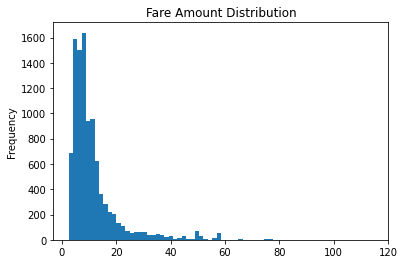

In [29]:
%%time
df["fare_amount"].plot.hist(bins=70, alpha=1, title="Fare Amount Distribution")

### 7b - Ride fare vs. ride length


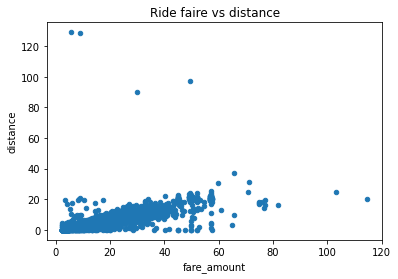

In [30]:
df.plot(kind='scatter', x='fare_amount', y='distance', title='Ride fare vs distance')

### 7c - Average ride length per pick up time hour of the day (x-axis = 24 hours)

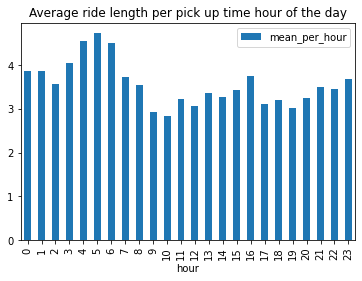

In [31]:
mean_per_hour = []
for h in range(24):
    mean_per_hour += [(df[df['hour'] == h].distance).mean()]
df_to_plot = pd.DataFrame({'mean_per_hour': mean_per_hour, 'hour': list(range(0, 24))})
df_to_plot.plot(kind='bar', x='hour', y='mean_per_hour', title="Average ride length per pick up time hour of the day")

### Feature assembling

In [17]:
%%time
# Building the vector assembler of the features
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['distance', 'hour', 'passenger_count', 'minute', 'day_of_month', 'month', 'day_of_week', 'year', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], outputCol='Features')
model_train = assembler.transform(train_data)
model_test = assembler.transform(test_data)

CPU times: user 13.5 ms, sys: 0 ns, total: 13.5 ms
Wall time: 356 ms


### Evaluator initialization

In [18]:
evaluator = BinaryClassificationEvaluator(labelCol='high_fare', metricName='areaUnderROC')

### Split train model into train and test 

In [19]:
(training_data_simulation, test_data_simulation) = model_train.randomSplit([0.8, 0.2])

### 9-10) Random Forest with 1 worker

In [20]:
%%time
"""Running Random Forest on 80% of data with 1 worker,
then testing on the training data and on the testing data (the other 20%)"""

rfAlgo = RandomForestClassifier(featuresCol='Features', labelCol='high_fare', numTrees=20, maxDepth=7)
rfModel = rfAlgo.fit(training_data_simulation)
predictions_train_data_RF = rfModel.transform(training_data_simulation)
print('Random Forest Results\n')
print("Training:", evaluator.evaluate(predictions_train_data_RF))
predictions_test_data_RF = rfModel.transform(test_data_simulation)
print("Test:", evaluator.evaluate(predictions_test_data_RF))

Random Forest Results

Training: 0.9370488673095558
Test: 0.9369289292111552
CPU times: user 900 ms, sys: 102 ms, total: 1 s
Wall time: 1h 40min 57s


### 9-10) Random Forest with 10 workers

In [64]:
%%time
"""Running Random Forest on 80% of data with 10 workers,
then testing on the training data and on the testing data (the other 20%)"""

rfAlgo = RandomForestClassifier(featuresCol='Features', labelCol='high_fare', numTrees=20, maxDepth=7)
rfModel = rfAlgo.fit(training_data_simulation)
predictions_train_data_RF = rfModel.transform(training_data_simulation)
print('Random Forest Results\n')
print("Training:", evaluator.evaluate(predictions_train_data_RF))
predictions_test_data_RF = rfModel.transform(test_data_simulation)
print("Test:", evaluator.evaluate(predictions_test_data_RF))

Random Forest Results

Training: 0.936079690006069
Test: 0.9364771493008219
CPU times: user 261 ms, sys: 27 ms, total: 288 ms
Wall time: 36min 16s


### Printing Confusion Matrix - training prediction

In [49]:
preds_and_labels = predictions_train_data_RF.select(['prediction','high_fare']).withColumn('label', F.col('high_fare').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[8808358.  610769.]
 [1294818. 4754832.]]


### Printing Confusion Matrix - testing prediction

In [53]:
preds_and_labels = predictions_test_data_RF.select(['prediction','high_fare']).withColumn('label', F.col('high_fare').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[2203016.  151924.]
 [ 324463. 1189361.]]


### 9-10) Linear regression - scaling the data before running the training

In [21]:
%%time
# Scaling the Features before running Logistic Regression
from sklearn import preprocessing
from pyspark.ml.feature import StandardScaler
sScaler = StandardScaler(
    withMean=True, withStd=True, inputCol="Features", outputCol="Features_scaled"
)

training_data_simulation_scaled = sScaler.fit(training_data_simulation).transform(training_data_simulation)
test_data_simulation_scaled = sScaler.fit(test_data_simulation).transform(test_data_simulation)

CPU times: user 48.2 ms, sys: 14.3 ms, total: 62.6 ms
Wall time: 3min 11s


### 9-10) Running Logistic regression with 1 worker

In [27]:
%%time
"""Running Logistic Regression on 80% of data with 1 workers,
then testing on the training data and on the testing data (the other 20%)"""

lralgo = LogisticRegression(featuresCol='Features_scaled', labelCol='high_fare', maxIter=5, regParam=0.5, elasticNetParam=0.1)
lrModel = lralgo.fit(training_data_simulation_scaled)
print('Logistic Regression Results\n')

predictions_train_data_LR = lrModel.transform(training_data_simulation_scaled)
print("Training:", evaluator.evaluate(predictions_train_data_LR))

predictions_test_data_LR = lrModel.transform(test_data_simulation_scaled)
print("Test:", evaluator.evaluate(predictions_test_data_LR))

Logistic Regression Results

Training: 0.9331308964292795
Test: 0.9332259205018376
CPU times: user 428 ms, sys: 38.4 ms, total: 467 ms
Wall time: 43min 11s


### 9-10) Running Logistic regression with 10 workers

In [22]:
%%time
"""Running Logistic Regression on 80% of data with 10 workers,
then testing on the training data and on the testing data (the other 20%)"""

lralgo = LogisticRegression(featuresCol='Features_scaled', labelCol='high_fare', maxIter=5, regParam=0.5, elasticNetParam=0.1)
lrModel = lralgo.fit(training_data_simulation_scaled)
print('Logistic Regression Results\n')

predictions_train_data_LR = lrModel.transform(training_data_simulation_scaled)
print("Training:", evaluator.evaluate(predictions_train_data_LR))

predictions_test_data_LR = lrModel.transform(test_data_simulation_scaled)
print("Test:", evaluator.evaluate(predictions_test_data_LR))

Logistic Regression Results

Training: 0.933135570926027
Test: 0.9332286930099112
CPU times: user 98.6 ms, sys: 16 ms, total: 115 ms
Wall time: 4min 58s


### Printing Confusion Matrix - training prediction

In [62]:
%%time
preds_and_labels = predictions_train_data_LR.select(['prediction','high_fare']).withColumn('label', F.col('high_fare').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
matrix = metrics.confusionMatrix().toArray()
print('[' + str(matrix[0]))
print(' [ ' + str(matrix[1][1])[:-1] + ' ' + str(matrix[1][0])[:-1] + ']]')


[[9447757.   10815.]
 [ 477021. 5589430.]]
CPU times: user 102 ms, sys: 10.5 ms, total: 113 ms
Wall time: 13min 31s


### Printing Confusion Matrix - testing prediction

In [63]:
%%time
preds_and_labels = predictions_test_data_LR.select(['prediction','high_fare']).withColumn('label', F.col('high_fare').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
matrix = metrics.confusionMatrix().toArray()
print('[' + str(matrix[0]))
print(' [ ' + str(matrix[1][1])[:-1] + ' ' + str(matrix[1][0])[:-1] + ']]')

[[2362718.    2686.]
 [ 122570. 1393581.]]
CPU times: user 87.2 ms, sys: 11.6 ms, total: 98.8 ms
Wall time: 11min 4s


### 12) Running model on whole data and using idc_test.csv as test and finally submitting model to Kaggle

### Create RF model over all data

In [21]:
%%time
# Creating final model of all training data 
rfAlgo = RandomForestClassifier(featuresCol='Features', labelCol='high_fare', numTrees=41, maxDepth=18)
rfModel_final = rfAlgo.fit(model_train)

CPU times: user 475 ms, sys: 42.4 ms, total: 517 ms
Wall time: 52min 34s


### Create prediction for RF on idc_test to submit to Kaggle

In [22]:
%%time
# Creating prediction for real test data
out_prediction = rfModel_final.transform(model_test)
out_prediction = out_prediction.select('key', 'prediction')
out_prediction.show(10)

+--------+----------+
|     key|prediction|
+--------+----------+
|19990001|       0.0|
|19990002|       1.0|
|19990003|       0.0|
|19990004|       0.0|
|19990005|       0.0|
|19990006|       0.0|
|19990007|       0.0|
|19990008|       1.0|
|19990009|       0.0|
|19990010|       0.0|
+--------+----------+
only showing top 10 rows

CPU times: user 20.9 ms, sys: 4.88 ms, total: 25.8 ms
Wall time: 56.2 s


In [23]:
%%time
# Outputting the prediction results to csv file
result = out_prediction.select(['key',col("prediction").alias("high_fare")])
result.write.csv('idc_prediction_5')

CPU times: user 11.8 ms, sys: 1.1 ms, total: 12.9 ms
Wall time: 53.8 s


In [24]:
%%time
# Saving csv file
!hadoop fs -copyToLocal idc_prediction_5

CPU times: user 74.7 ms, sys: 4.27 ms, total: 78.9 ms
Wall time: 3.69 s


In [28]:
%%time
# Trying Logistic regression

# Scaling data first
train_data_scaled = sScaler.fit(model_train).transform(model_train)
test_data_scaled = sScaler.fit(model_test).transform(model_test)

"""Running Logistic Regression on real test data"""
lralgo = LogisticRegression(featuresCol='Features_scaled', labelCol='high_fare', maxIter=20, regParam=0.5, elasticNetParam=0.1)
lrModel_final = lralgo.fit(train_data_scaled)
out_prediction_lr = lrModel_final.transform(test_data_scaled)
out_prediction_lr = out_prediction_lr.select('key', 'prediction')
# Outputting the prediction results to csv file
result_lr = out_prediction_lr.select(['key',col("prediction").alias("high_fare")])
result_lr.write.csv('idc_prediction_4')
# Saving csv file
!hadoop fs -copyToLocal idc_prediction_4

CPU times: user 165 ms, sys: 33.2 ms, total: 198 ms
Wall time: 5min 55s


### 14) Extra challange - regression model to predict the ride fare

In [21]:
%%time
# Scaling the Features before running Logistic Regression
sScaler = StandardScaler(
    withMean=True, withStd=True, inputCol="Features", outputCol="Features_scaled"
)

training_data_simulation_scaled = sScaler.fit(training_data_simulation).transform(training_data_simulation)
test_data_simulation_scaled = sScaler.fit(test_data_simulation).transform(test_data_simulation)

CPU times: user 682 ms, sys: 106 ms, total: 787 ms
Wall time: 30min 1s


In [22]:
%%time
# Running Linear Regression on 80% of training data with 1 worker
liralgo = LinearRegression(featuresCol='Features_scaled', labelCol='fare_amount', maxIter=5, regParam=0.5, elasticNetParam=0.1)
print('Running Linear regression model to predit the fare_amount')
lirModel = liralgo.fit(training_data_simulation_scaled)
trainingSummary = lirModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Running Linear regression model to predit the fare_amount
RMSE: 7.624226
r2: 0.371952
CPU times: user 535 ms, sys: 51.6 ms, total: 587 ms
Wall time: 1h 11s


In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
print('Evaluating...')
predictions_train_data_LIR = lirModel.transform(training_data_simulation_scaled)
predictions_test_data_LIR = lirModel.transform(test_data_simulation_scaled)
lir_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="fare_amount", metricName="r2")
print('Training:\n')
predictions_train_data_LIR.select("prediction","fare_amount","features").show(10)
print("r2 training score = %g" % lir_evaluator.evaluate(predictions_train_data_LIR))
print('Test:\n')
predictions_test_data_LIR.select("prediction","fare_amount","features").show(10)
print("r2 test score = %g" % lir_evaluator.evaluate(predictions_test_data_LIR))

Evaluating...
Training:

+------------------+-----------+--------------------+
|        prediction|fare_amount|            features|
+------------------+-----------+--------------------+
| 9.567494408688233|        8.5|[2.88478794076426...|
| 9.958527596665178|        9.7|[2.52386178889966...|
| 9.812316817699424|        7.7|[1.93696733468743...|
| 11.57827869745985|        7.5|[3.19888556594717...|
|  8.96310501802606|        9.7|[2.00235187154415...|
|7.8249672594998145|        3.7|[0.54952085836564...|
| 8.021014033556844|        4.5|[0.48650039691888...|
| 8.848479110533104|        4.9|[0.99854109945385...|
| 10.85361758744772|        7.7|[2.71395909812549...|
|16.250322133471563|       20.0|[7.83641737335194...|
+------------------+-----------+--------------------+
only showing top 10 rows

r2 training score = 0.371952
Test:

+------------------+-----------+--------------------+
|        prediction|fare_amount|            features|
+------------------+-----------+-----------------